In [123]:
mp = 0.93827                                                           #proton mass
pz = 158.0                                                             #beam momentum
root_s = (2 * mp * (mp + (mp ** 2 + pz ** 2) ** 0.5)) ** 0.5           #sqrt(s)
norm = 3.141593 * root_s / 2                                           #normalization in new coordinats
sig_trig = 28.23                                                       #trigger cross section

> ## Generating

In [124]:
import sys

sys.path.insert(0, '/opt/homebrew/Cellar/pythia/8.309/lib')

import pythia8

In [125]:
N_events = int(1e7) 
ids = [-211, 211, -321, 321]

In [126]:
import os
from tqdm import tqdm

In [127]:
def gen_data(exp_name, conf_file, tune_pp=14, n_events=int(1e6)):

    try:
    
        os.mkdir(f'gen_data/{exp_name}')
    
    except FileExistsError: pass

    pythia = pythia8.Pythia("", False)

    files = dict(zip(ids, [open(f'gen_data/{exp_name}/{id}.csv', 'w') for id in ids]))

    for id in ids: files[id].write('pT,xF,E\n')

    pythia.readFile(conf_file)
    pythia.readString(f'Tune:pp = {tune_pp}')

    boost = pythia8.Vec4()
    boost.pz(mp * ((1 + (pz / mp) ** 2) ** 0.5 - 1) ** 0.5)
    boost.e((boost.pz() ** 2 + mp ** 2) ** 0.5)

    pythia.init()

    for _ in tqdm(range(n_events)):

        if not pythia.next(): continue
        
        entries = pythia.event.size()

        for j in range(entries):

            particle = pythia.event[j]

            id = particle.id()
            
            if abs(int(id)) == 211 or abs(int(id)) == 321:

                P_mu = particle.p()

                P_mu.bstback(boost)

                pT = P_mu.pT()
                xF = 2 * P_mu.pz() / root_s
                E = P_mu.e()

                files[id].write(f'{pT},{xF},{E}\n')

    sig_total = pythia.getSigmaTotal()

    sigma_file = open(f'gen_data/{exp_name}/sigma_total.txt', 'w')
    sigma_file.write(f'{sig_total}')
    sigma_file.close()

    for id in ids: files[id].close()

In [128]:
tunes = {'primitive': {'tune_pp': 1},
         'monash': {'tune_pp': 14},
         'atlas_a14': {'tune_pp': 19}}

In [129]:
for tune in tunes.keys():

    gen_data(exp_name=tune,
         conf_file='../exp_data/na49/config.cmnd', 
         tune_pp=tunes[tune]['tune_pp'],
         n_events=N_events)

100%|██████████| 10000000/10000000 [23:54<00:00, 6971.79it/s] 


LHAPDF 6.5.3 loading /opt/homebrew/Cellar/lhapdf/6.5.3/share/LHAPDF/cteq6l1/cteq6l1_0000.dat
cteq6l1 PDF set, member #0, version 4; LHAPDF ID = 10042
LHAPDF 6.5.3 loading /opt/homebrew/Cellar/lhapdf/6.5.3/share/LHAPDF/cteq6l1/cteq6l1_0000.dat
cteq6l1 PDF set, member #0, version 4; LHAPDF ID = 10042


100%|██████████| 10000000/10000000 [30:29<00:00, 5465.52it/s] 


In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [131]:
sig_totals = {}

for tune in tunes.keys():

    sigma_file = open(f'gen_data/{tune}/sigma_total.txt', 'r')
    sig_total = float(sigma_file.readline())
    sigma_file.close()

    sig_totals[tune] = sig_total

In [132]:
bins_file = open('../exp_data/na49/binning.bin', 'r')

In [133]:
bins = []

for num, line in enumerate(bins_file.readlines()):

    if num % 2 == 0:
        
        a = line.split('|')

        for bin in a:

            bin = bin.replace('(', '').replace(')', '').replace(' ', '')
            bins.append(list(map(float, bin.split(','))))

bins = np.array(bins)

bins_file.close()

In [134]:
def xsect_calc(data, sig_total):

    xsect = []
    err = []

    for bin in bins:

        xF = bin[0]
        pT = bin[1]

        dxF = bin[2]
        dpT = bin[3]

        mask_for_bin = (data['xF'] > xF - dxF / 2) * (data['xF'] < xF + dxF / 2) * (data['pT'] > pT - dpT / 2) * (data['pT'] < pT + dpT / 2)

        dn = data[mask_for_bin]['E'].size

        dp3 = dxF * 2 * pT * dpT

        E = data[mask_for_bin]['E']

        xsect.append((E * (sig_total / N_events) * (dn / dp3) / norm).mean())
        err.append((E * (sig_total / N_events) * (dn / dp3) / norm).std())

    xsect = np.where(np.isnan(xsect), 0, xsect)
    err = np.where(np.isnan(err), 0, err)

    return xsect, err

In [135]:
def plot_compare(tunes, xsect, err, ref):

    n = ref['xF'].unique().size

    plt.figure(figsize=(20, 7 * n))

    for num, xF in enumerate(ref['xF'].unique()):

        pT_axis = np.intersect1d(bins[:, 1][bins[:, 0] == xF][::-1], ref['pT'][ref['xF'] == xF])

        plt.subplot(n, 3, num * 3 + 1)

        for tune in tunes:

            plt.errorbar(pT_axis, xsect[tune][(bins[:, 0] == xF) * np.isin(bins[:, 1], pT_axis)][::-1],
                         yerr=err[tune][(bins[:, 0] == xF) * np.isin(bins[:, 1], pT_axis)][::-1], label=tune)
            
        plt.errorbar(pT_axis, ref['xsect'][(ref['xF'] == xF) * np.isin(ref['pT'], pT_axis)], 
                    yerr=ref['error'][(ref['xF'] == xF) * np.isin(ref['pT'], pT_axis)],
                    label='exp')
        plt.xlim((0, 2.15))
        plt.legend()
        plt.title(f'$xF={xF}$')

        plt.subplot(n, 3, num * 3 + 2)

        for tune in tunes:

            plt.errorbar(pT_axis, xsect[tune][(bins[:, 0] == xF) * np.isin(bins[:, 1], pT_axis)][::-1],
                         yerr=err[tune][(bins[:, 0] == xF) * np.isin(bins[:, 1], pT_axis)][::-1], label=tune)
            
        plt.errorbar(pT_axis, ref['xsect'][(ref['xF'] == xF) * np.isin(ref['pT'], pT_axis)], 
                    yerr=ref['error'][(ref['xF'] == xF) * np.isin(ref['pT'], pT_axis)],
                    label='exp')
        plt.yscale('log')
        plt.xlim((0, 2.15))
        plt.legend()
        plt.title(f'$xF={xF}$ log scale')

        delta = {}
        delta_err = {}

        for tune in tunes:

            delta[tune] = ((xsect[tune][(bins[:, 0] == xF) * np.isin(bins[:, 1], pT_axis)][::-1] - ref['xsect'][(ref['xF'] == xF) * np.isin(ref['pT'], pT_axis)]) /
                     ref['xsect'][(ref['xF'] == xF) * np.isin(ref['pT'], pT_axis)])
            delta_err[tune] = delta[tune] * ((err[tune] / np.where(xsect[tune] == 0, 1, xsect[tune]))[(bins[:, 0] == xF) * np.isin(bins[:, 1], pT_axis)][::-1] +
                                 (ref['error'] / ref['xsect'])[(ref['xF'] == xF) * np.isin(ref['pT'], pT_axis)])

        plt.subplot(n, 3, num * 3 + 3)

        for tune in tunes:
            
            plt.errorbar(pT_axis, delta[tune], yerr=np.abs(delta_err[tune]), label=tune)
        
        plt.plot(pT_axis, np.zeros_like(pT_axis), '--', color='red')
        plt.legend()
        plt.title(f'$xF={xF}$ relative deviation')
        
    plt.show()

> ## $\pi^{+}$ differential cross sectciont comparesment

In [136]:
id = 211

In [137]:
data = {}

for tune in tunes.keys():

    data[tune] = pd.read_csv(f'gen_data/{tune}/{id}.csv')

ref = pd.read_csv(f'../exp_data/na49/{id}.csv')

In [138]:
xsect = {}
err = {}

for tune in tunes.keys():

    xsect[tune], err[tune] = xsect_calc(data[tune], sig_totals[tune])

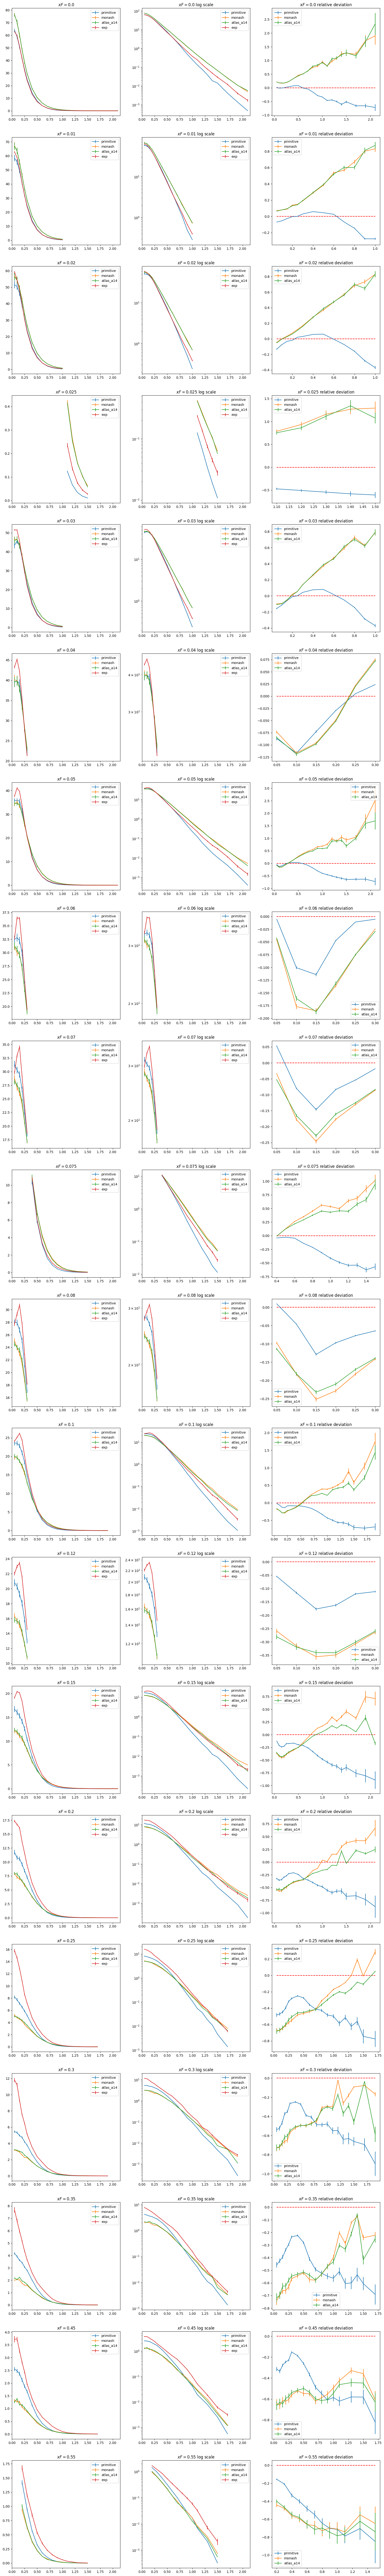

In [139]:
plot_compare(tunes.keys(), xsect, err, ref)

> ## $\pi^{-}$ differential cross sectciont comparesment

In [140]:
id = -211

In [141]:
data = {}

for tune in tunes.keys():

    data[tune] = pd.read_csv(f'gen_data/{tune}/{id}.csv')

ref = pd.read_csv(f'../exp_data/na49/{id}.csv')

In [142]:
xsect = {}
err = {}

for tune in tunes.keys():

    xsect[tune], err[tune] = xsect_calc(data[tune], sig_totals[tune])

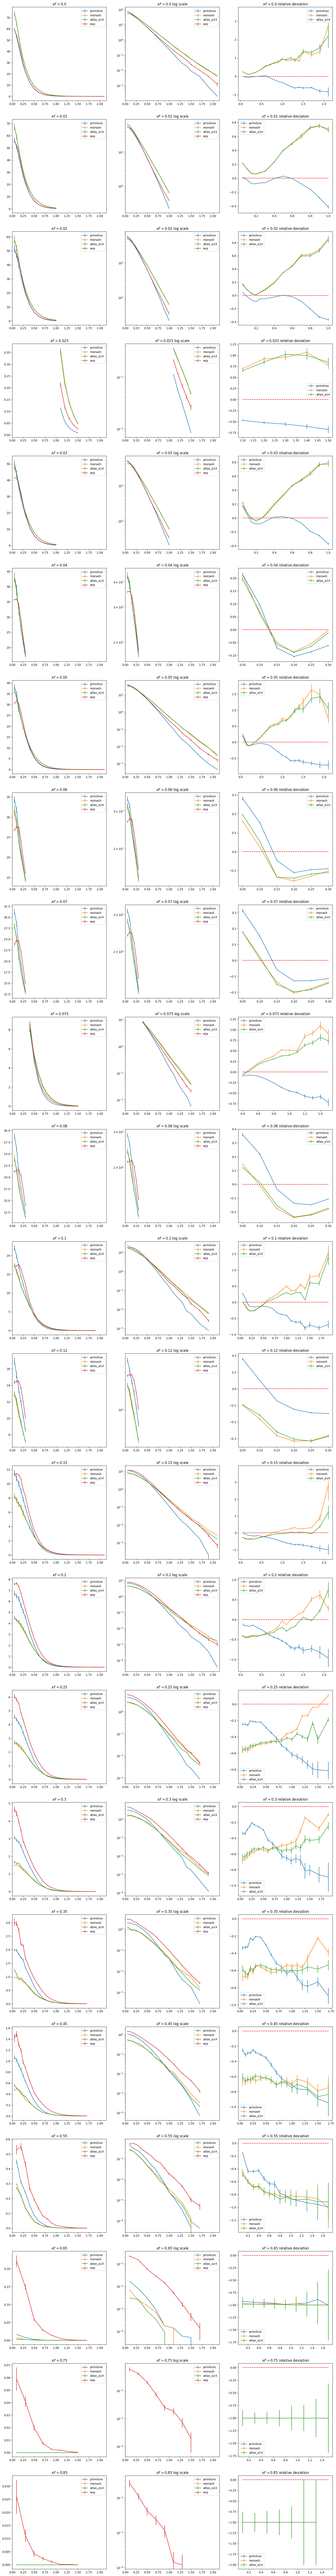

In [143]:
plot_compare(tunes.keys(), xsect, err, ref)

> ## $K^{+}$ differential cross sectciont comparesment

In [144]:
id = 321

In [153]:
data = {}

for tune in tunes.keys():

    data[tune] = pd.read_csv(f'gen_data/{tune}/{id}.csv')

ref = pd.read_csv(f'../exp_data/na49/{id}.csv')

In [154]:
xsect = {}
err = {}

for tune in tunes.keys():

    xsect[tune], err[tune] = xsect_calc(data[tune], sig_totals[tune])

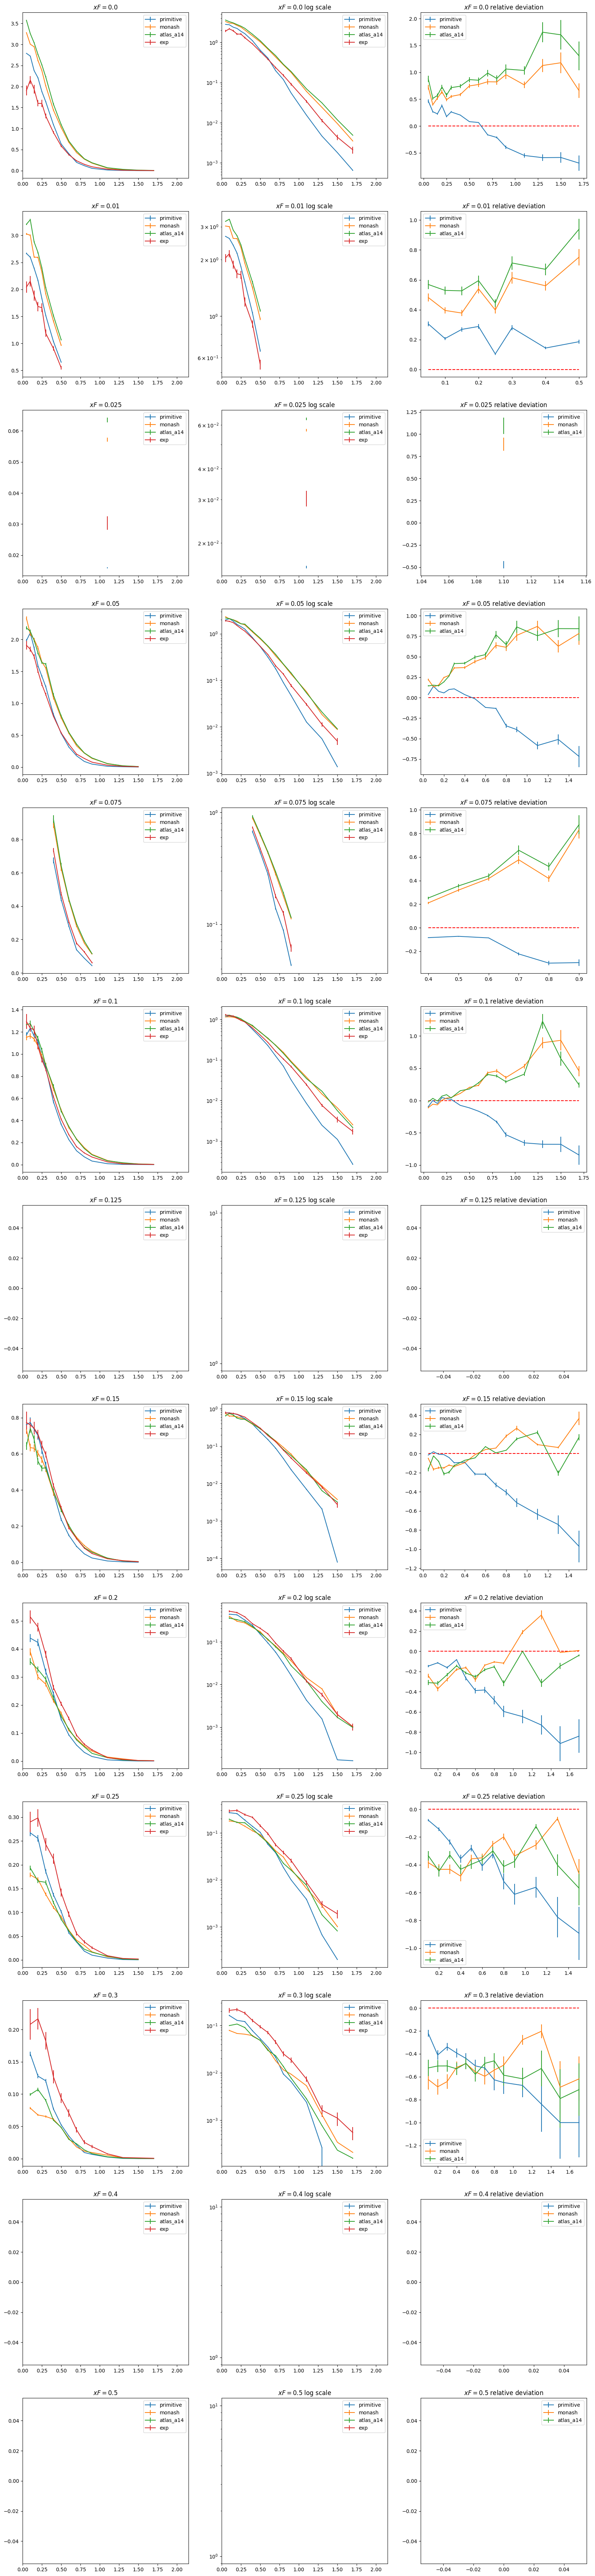

In [155]:
plot_compare(tunes.keys(), xsect, err, ref)

> ## $K^{-}$ differential cross sectciont comparesment

In [148]:
id = -321

In [149]:
data = {}

for tune in tunes.keys():

    data[tune] = pd.read_csv(f'gen_data/{tune}/{id}.csv')

ref = pd.read_csv(f'../exp_data/na49/{id}.csv')

In [150]:
xsect = {}
err = {}

for tune in tunes.keys():

    xsect[tune], err[tune] = xsect_calc(data[tune], sig_totals[tune])

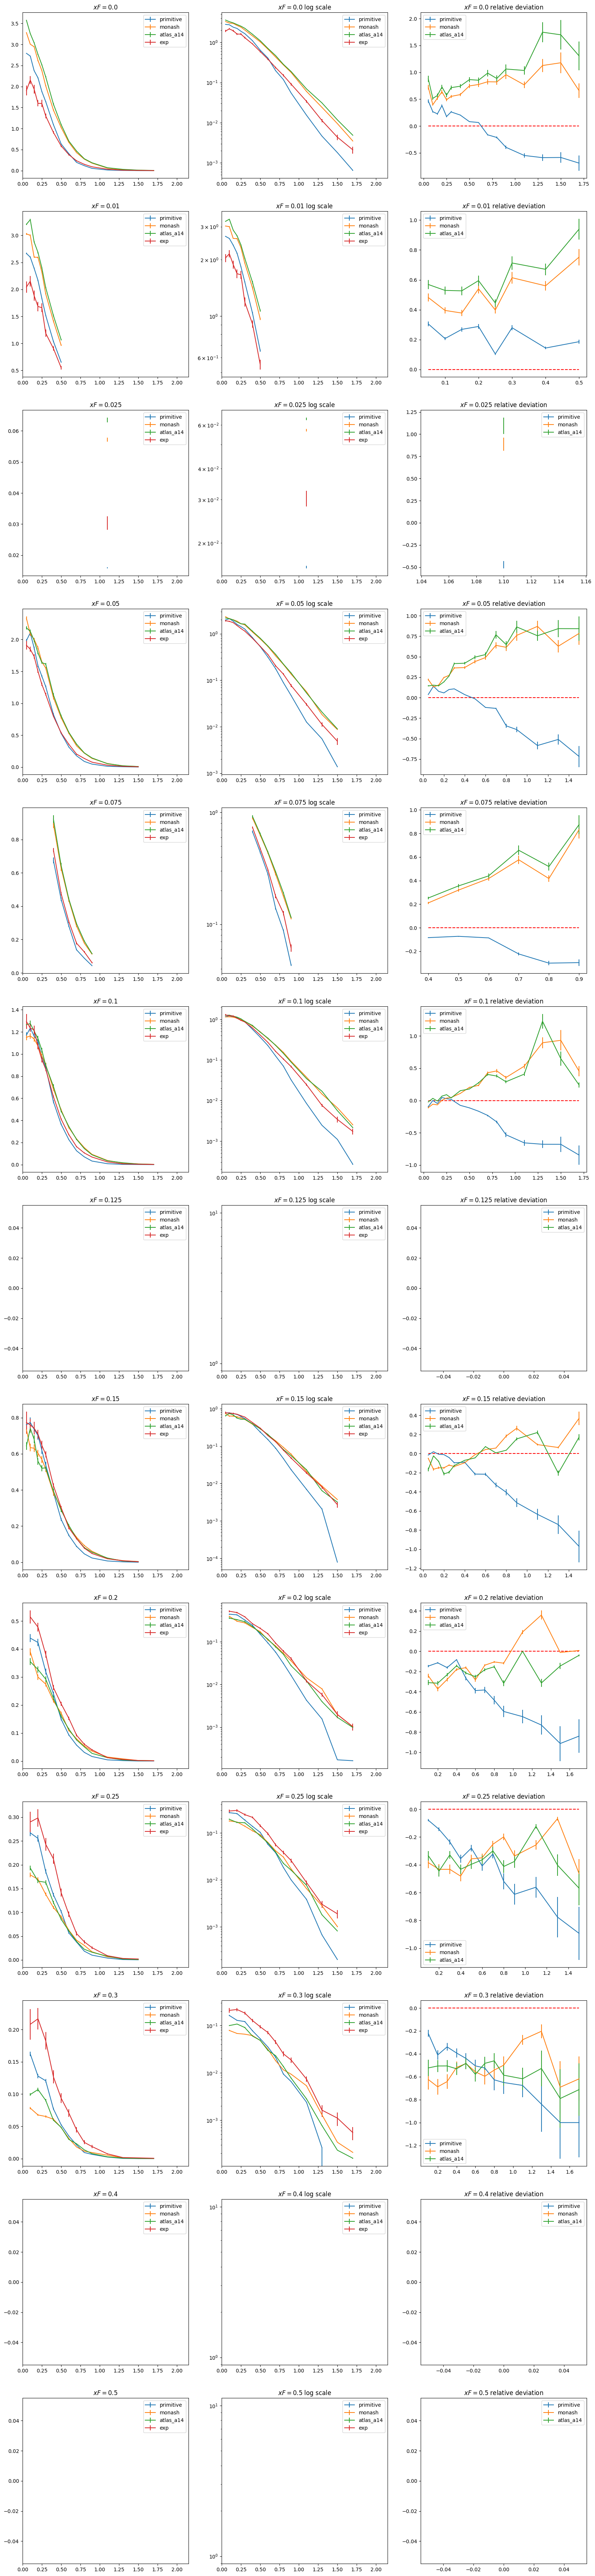

In [151]:
plot_compare(tunes.keys(), xsect, err, ref)

># Conclusion

Tunes `monash` and `ATLAS A14` are close to each other because `ATLAS A14` was derived from `monash`. It is hard to say what tune is better but for low values of $x_F$ and $p_T$ it seems that `primitive` tune is more consistent wuth experimental data. The results are unsatisfying, so before starting a development of the optimizer the absence of mistakes in the previous works has to be verified.